# Credit Card Fraud Detection and Prediction Using Restricted Boltzmann Machine(RBM)
This project demonstrates the use of unsupervised training for Credit Card Fraud Detection and Prediction. The main model implemented here is Restricted Boltzmann Machine(RBM), which achives 0.96 of AUC on test set. 

# Load libraries 

In [3]:
import pandas as pd
import numpy as np
import pickle

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
tf.compat.v1.disable_eager_execution()
import os
from datetime import datetime 
import seaborn as sns

from pylab import rcParams
import sklearn
from sklearn.metrics import roc_auc_score as auc 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 10, 10

LABELS = ["Normal", "Fraud"]

# Data Exploration

The dataset we're going to use can be downloaded from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud).The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [4]:
data_fdp = pd.read_csv('../input/creditcardfraud/creditcard.csv')

In [5]:
data_fdp.isnull().values.any()

False

In [6]:
data_fdp.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
print("Credit Card Fraud Detection data -  rows:",data_fdp.shape[0]," columns:", data_fdp.shape[1])

Credit Card Fraud Detection data -  rows: 284807  columns: 31


In [8]:
data_fdp.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
print("Total transaction time span: {:.1f} days".format(data_fdp['Time'].max() / (3600 * 24.0)))
print("With {:.3f} % of transactions are fraud. ".format(np.sum(data_fdp['Class']) / data_fdp.shape[0] * 100))

Total transaction time span: 2.0 days
With 0.173 % of transactions are fraud. 


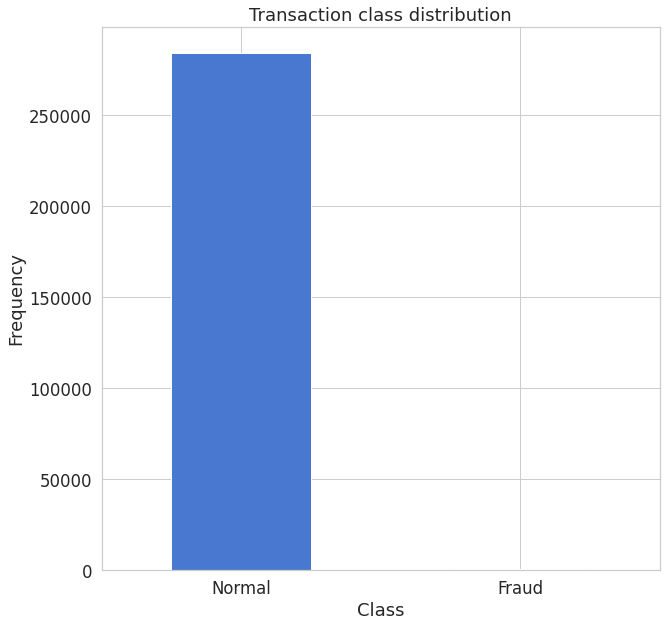

In [10]:
count_classes = pd.value_counts(data_fdp['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions: 

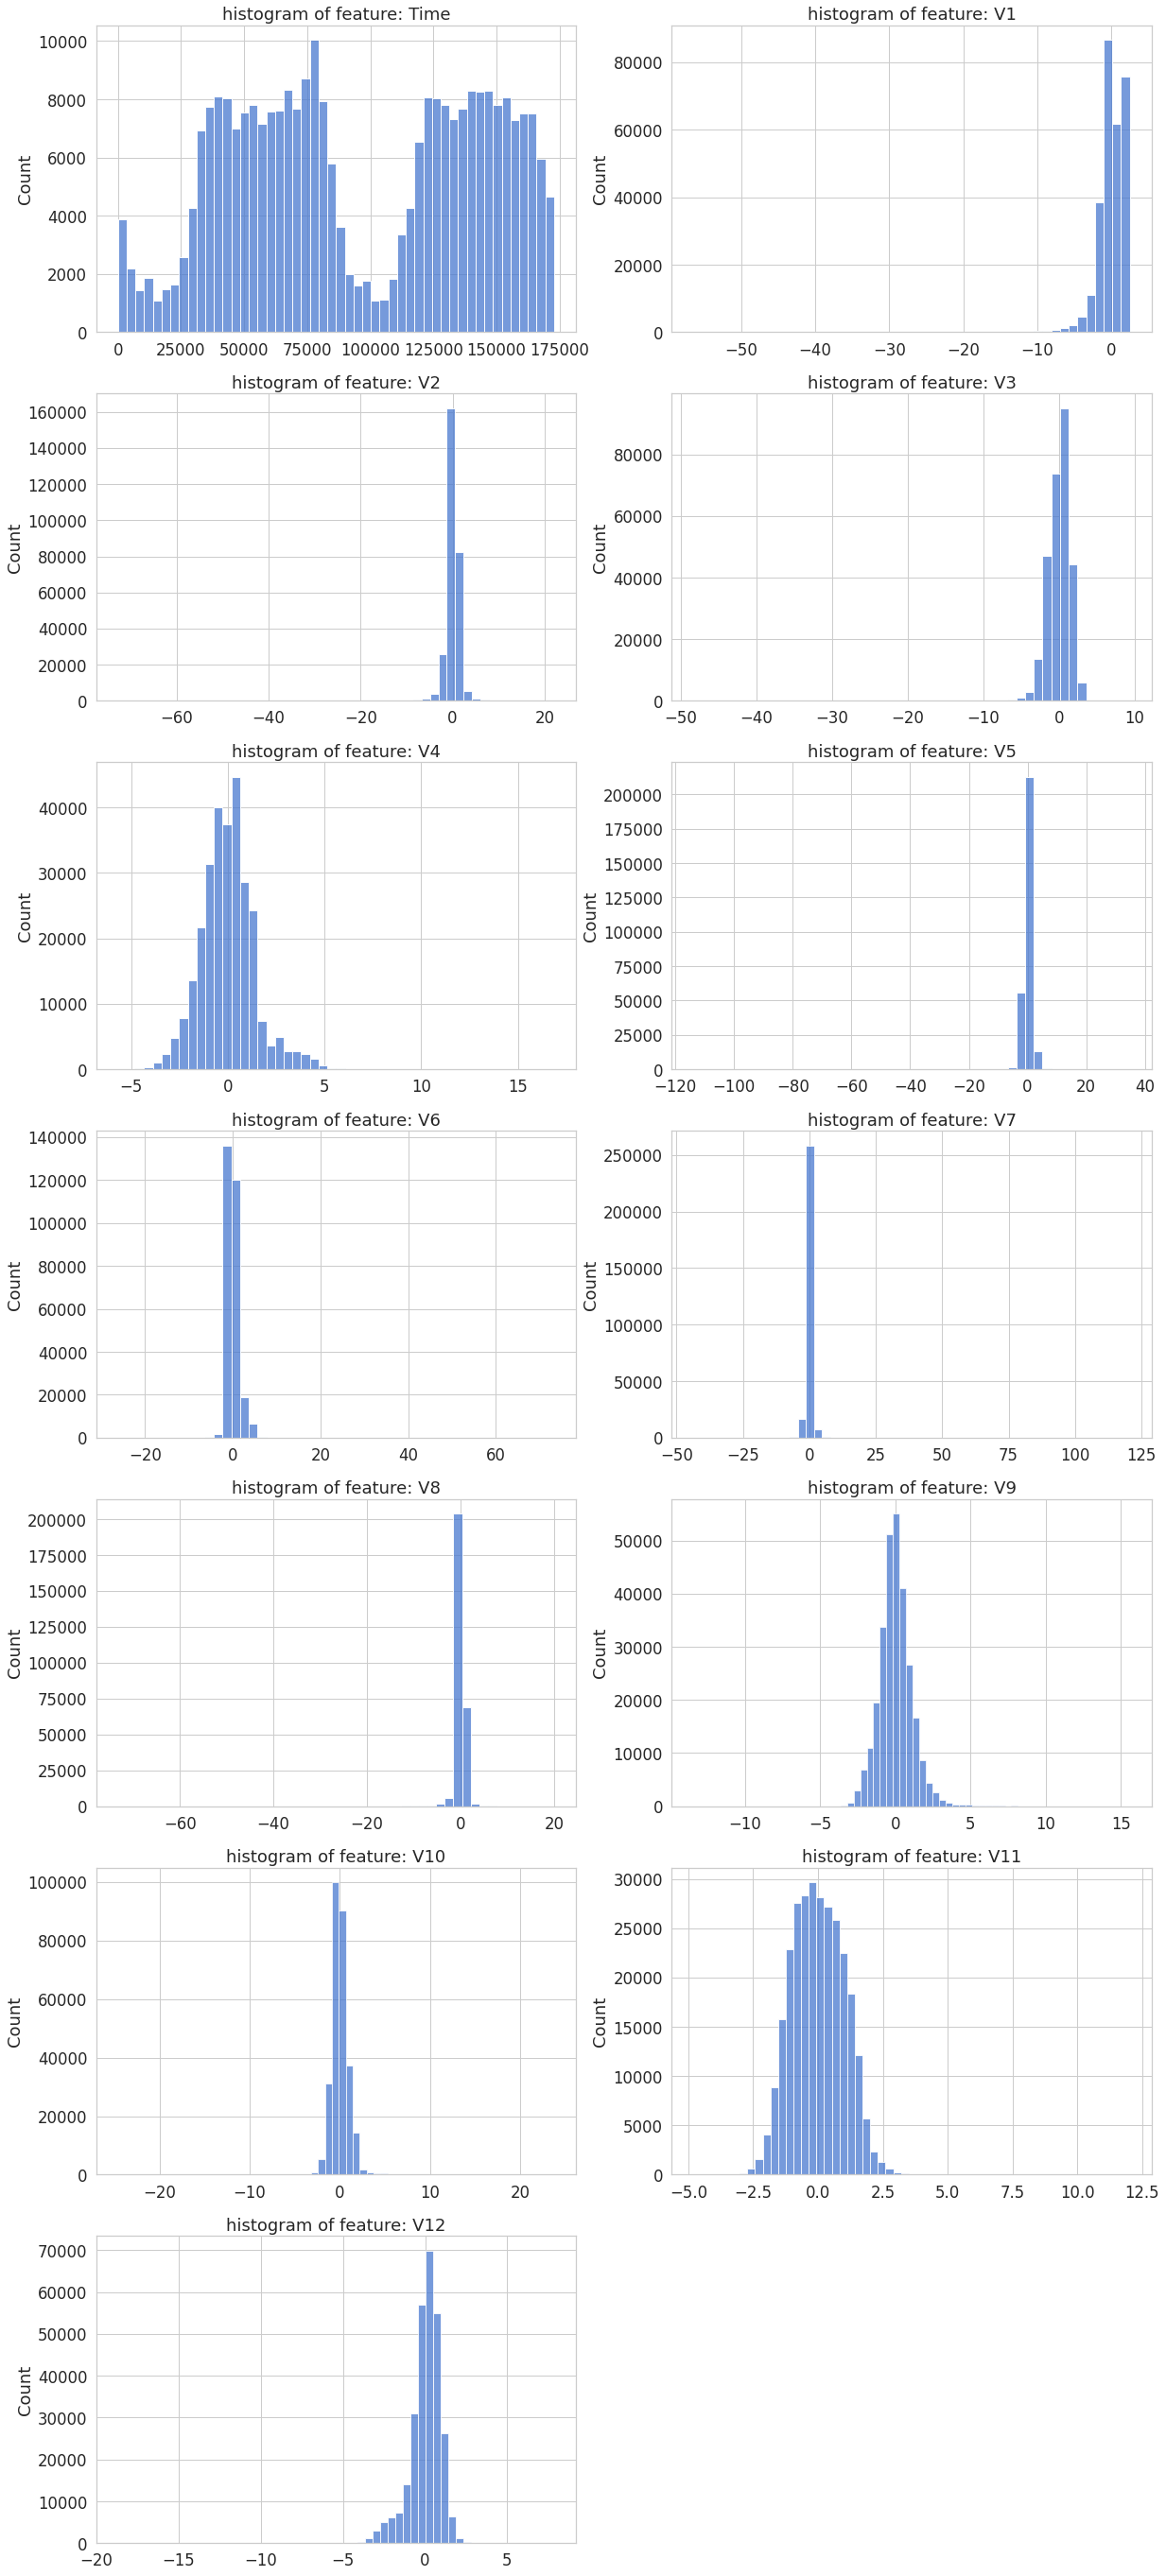

In [11]:
plt.figure(figsize=(20,7*7))
gs = gridspec.GridSpec(7, 2)
for i, cn in enumerate(data_fdp.columns[:13]):
    ax = plt.subplot(gs[i])
    sns.histplot(data_fdp[cn][data_fdp.Class == 1], bins=50)
    sns.histplot(data_fdp[cn][data_fdp.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

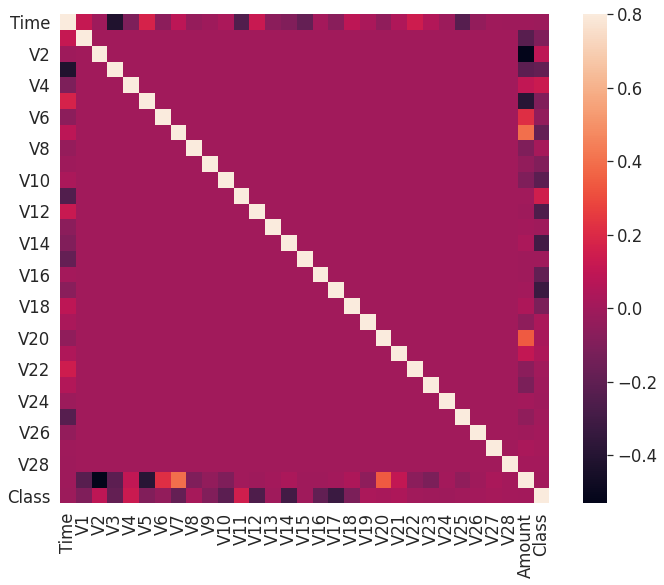

In [12]:
corrmat = data_fdp.corr()
fig = plt.figure(figsize = (12, 9))
sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

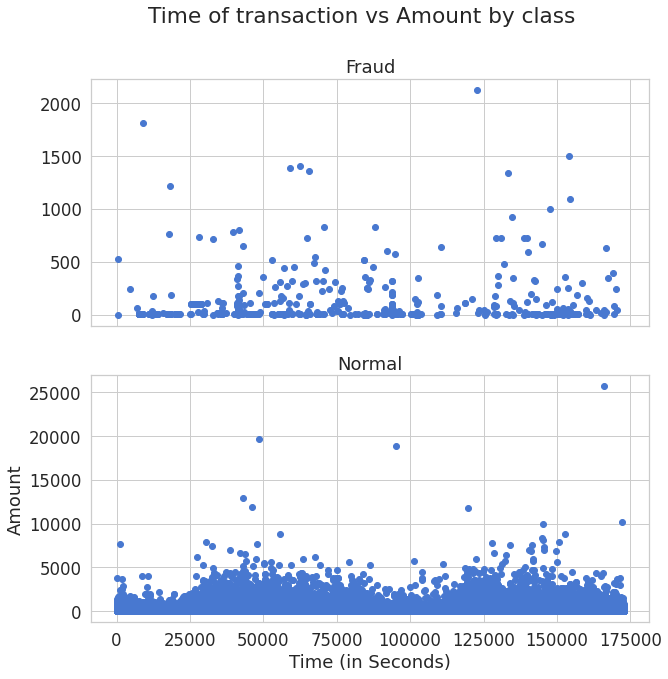

In [13]:
frauds = data_fdp[data_fdp.Class == 1]
normal = data_fdp[data_fdp.Class == 0]

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

# Restricted Boltzmann Machine(RBM)

Restricted Boltzmann Machine(RBM) was one of the earliest models introduced in the world of deep learning. There have been many successful use cases of RBM in areas such as dimensionality reduction, classification, collaborative filtering, feature learning as well as anomaly detection. Basically, a RBM network consists of two layers – the Visible Layer and Hidden layer. There are symmetric connections between any pair of nodes from Visible and Hidden layers, and no connections within each layer.

For majority cases, both hidden and visible layers are binary-valued. There are also extensions with visible layer being **Gaussian**, and hidden layer being **Bernoulli**. The latter will be our case for fraud detection and prediction. (Since our input data will be normalized into Mean of 0 and Standard Deviation of 1). Here's a visual representation of a Restricted Boltzmann Machine:

![](https://vanishingcodes.files.wordpress.com/2017/07/screen-shot-2017-07-27-at-5-25-15-pm.png)

When signals propagate from visible to hidden, the input layer (i.e. the data sample) will be multiplied by the matrix **W**, added with bias vector **b** of hidden layer, and finally go through the sigmoid function to be squashed to be within 0 and 1, which are also the probabilities for each hidden node to be on. **However, it is very important to keep the hidden states binary (0 or 1 for each), rather than using the probabilities itself*. And only during the last update of the gibbs sampling should we use probabilities for hidden layer**, which we will talk about later on.

During backward pass, or reconstruction, the hidden layer activation will become the input, which is multiplied by the **same matrix W**, added with visible **biases**, and then will either go through the **sigmoid function** (for Bernoulli visible), or being sampled from a multivariate **Gaussian distribution** (for Gaussian visible), as below:

![](https://vanishingcodes.files.wordpress.com/2017/08/capture.png)

Intuitively, we can understand that the model is adjusting its weights, during training, such that it could best approximate the **training data distribution p** with its **reconstruction distribution q**, as below:

![](https://vanishingcodes.files.wordpress.com/2017/08/capture2.png)

We first define our so-called **Energy Function E(x, h)**, as well as the **joint probability p(x, h)**, given any pair of visible and hidden layers, as below:

![](https://vanishingcodes.files.wordpress.com/2017/08/capture5.png)

In the above equations, **x** is the visible layer, **h** is the hidden layer activations, **W, b** and **c** are the matrix, hidden bias and visible bias, respectively.So basically, for any pair of x and h, we are able to calculate **E(x, h)**. Its value is a scalar. And the higher the value of Energy, the lower the **p(x, h)**.

1. 1. # Fraud Detection with Restricted Boltzmann Machine (RBM)

From the energy function, we are able to derive the equation below for so-called **Free Energy of x**:

![](https://vanishingcodes.files.wordpress.com/2017/08/capture6.png)

This Free Energy, F(x), which is also a scalar, is exactly what we will need for test data, from which we will use the distribution to detect anomalies. **The higher the free energy, the higher the chance of x being a fraud.** 


# Model Updating Perameters
To update our parameters **W, b** and **c**, we use below equations combined with SGD (the alpha is learning rate):

![](https://vanishingcodes.files.wordpress.com/2017/08/capture8.png)

The left part, **h(x<sup>(t)</sup>)x<sup>(t)<sup>T</sup></sup>**, is easy to calculate, as **x<sup>(t)</sup>** is just the training sample, and **h(x<sup>(t)</sup>)** is simply below:

![](https://vanishingcodes.files.wordpress.com/2017/08/capture11.png)

So the outcome is simply a vector multiplication which gives **same shape** as **W**.

Then use **gibbs sampling** to calculate ![](https://s0.wp.com/latex.php?latex=h%28%5Cwidetilde%7Bx%7D%29%5Cwidetilde%7Bx%7D%5E%7BT%7D&bg=ffffff&fg=222222&s=0&c=20201002):

![](https://vanishingcodes.files.wordpress.com/2017/08/capture12.png)

We start with a training sample **x<sup>(t)</sup>**, and sample each **h<sub>(j)</sub>** by first calculating:

![](https://vanishingcodes.files.wordpress.com/2017/08/capture14.png)

Then we draw a value from a **uniform distribution [0, 1]**, and if the drawn value is smaller than the one calculated above, we assign 1 to  h<sub>(j)</sub>, otherwise we assign 0. And then we do this for each  h<sub>(j)</sub> 

Next, we sample visible layer **x<sub>(k)</sub>**, by using previously sampled **hidden layer as input**, with a similar equation below:

![](https://vanishingcodes.files.wordpress.com/2017/08/capture15.png)

Here, we directly use the results from **sigmoid, without sampling** it into states of 0 and 1, to get visible layer.

However, we will do this step slightly different if the input data, or visible layer x, is a **Gaussian distribution**. If Gaussian, we will sample the x vector using **Gaussian** with **mean μ = c + W<sup>T</sup>h** as well as identity covariance matrix. This part is fully implemented in the code where you can check for verification (under equation **sample_visible_from_hidden**).

We will do this k steps, which is referred to as Contrastive Divergence, or CD<sub>(k)</sub>. 

After last step k, we will use the sampled visible layer as ![](https://s0.wp.com/latex.php?latex=%5Cwidetilde%7Bx%7D&bg=ffffff&fg=222222&s=0&c=20201002), together with the **last hidden probabilities** as ![](https://s0.wp.com/latex.php?latex=h%28%5Cwidetilde%7Bx%7D%29&bg=ffffff&fg=222222&s=0&c=20201002).
Note that what we are using here is the **probabilities, not the sampled 0 and 1 states, for** ![](https://s0.wp.com/latex.php?latex=h%28%5Cwidetilde%7Bx%7D%29&bg=ffffff&fg=222222&s=0&c=20201002).


In summary, the whole process of model updating is simplified into the following steps:

1. Start with training sample x – ![](https://s0.wp.com/latex.php?latex=x%5E%7B%28t%29%7D&bg=ffffff&fg=222222&s=0&c=20201002)
2. Sample h from input x        – ![](https://s0.wp.com/latex.php?latex=h%28x%5E%7B%28t%29%7D%29&bg=ffffff&fg=222222&s=0&c=20201002)
3. Sample x from h
4. Sample h from x
5. …
6. Sample x from h              – ![](https://s0.wp.com/latex.php?latex=%5Cwidetilde%7Bx%7D&bg=ffffff&fg=222222&s=0&c=20201002)
7. Sample h from x              – ![](https://s0.wp.com/latex.php?latex=h%28%5Cwidetilde%7Bx%7D%29&bg=ffffff&fg=222222&s=0&c=20201002)

In practice, using k = 1 can give a good result.

# Tuning Hyper-parameters

The data-driven approach is used.

1. Split the data into **training** and **validation** sets, and train the model on training set, to evaluate the performance on validation.
2. Start the hidden layer with a smaller dimension than input layer(e.g. 5, 10), set the learning rate to be a small value (such as 0.001), monitor the validation data set** reconstruction error** (not the actual error against labels)

The reconstruction error is basically the **mean squared** of the difference between predicted ![](https://s0.wp.com/latex.php?latex=%5Cwidetilde%7Bx%7D&bg=ffffff&fg=222222&s=0&c=20201002) and the actual data **x, averaged over the entire mini-batch. **

3. If the reconstruction error stops decreasing, that would be a sign for early-stopping.


# Training and validation
We split our data by transaction time into training and validation by 50 – 50, and train our model on the training set

We then train the model and calculate the Free Energy of val set, and visualize the distributions for both fraud as well as non-fraud samples.

In [14]:
TEST_RATIO = 0.5
data_fdp.sort_values('Time', inplace = True)
TRA_INDEX = int((1-TEST_RATIO) * data_fdp.shape[0])
train_x = data_fdp.iloc[:TRA_INDEX, 1:-2].values
train_y = data_fdp.iloc[:TRA_INDEX, -1].values

test_x = data_fdp.iloc[TRA_INDEX:, 1:-2].values
test_y = data_fdp.iloc[TRA_INDEX:, -1].values

In [15]:
print("Total train examples: {}, total fraud cases: {}, equal to {:.5f} of total cases. ".format
      (train_x.shape[0], np.sum(train_y), np.sum(train_y)/train_x.shape[0]))

Total train examples: 142403, total fraud cases: 269, equal to 0.00189 of total cases. 


In [16]:
print("Total test examples: {}, total fraud cases: {}, equal to {:.5f} of total cases. ".format(
    test_x.shape[0], np.sum(test_y), np.sum(test_y)/test_y.shape[0]))

Total test examples: 142404, total fraud cases: 223, equal to 0.00157 of total cases. 


# Data Pre-processing - z scores

Since the data are already PCA transformed, we will only need to standardize them with z-score to get mean of 0 and standard deviation of 1, training and validation data respectively


In [17]:
cols_mean = []
cols_std = []
for c in range(train_x.shape[1]):
    cols_mean.append(train_x[:,c].mean())
    cols_std.append(train_x[:,c].std())
    train_x[:, c] = (train_x[:, c] - cols_mean[-1]) / cols_std[-1]
    test_x[:, c] =  (test_x[:, c] - cols_mean[-1]) / cols_std[-1]

# Modeling and Result
### Import RBM Script

We then fit the data using model with Gaussian visible layer. (This is the Gaussian – Bernoulli RBM, since the hidden layer is still binary-valued)

In [18]:
from rbm_script import RBM

## Initialize model object with momentum

In [19]:
model = RBM(train_x.shape[1], 10, visible_unit_type='gauss', main_dir='../', model_name='rbm_model.ckpt',
                 gibbs_sampling_steps=4, learning_rate=0.001, momentum = 0.95, batch_size=512, num_epochs=10, verbose=1)


## Train the Model

We train and plot training Reconstruction loss v.s. Iteractions

Validation cost at step 0: 1.1127973
Validation cost at step 1: 1.063236
Validation cost at step 2: 1.0084523
Validation cost at step 3: 0.99369264
Validation cost at step 4: 0.9963241
Validation cost at step 5: 0.98761666
Validation cost at step 6: 0.99709475
Validation cost at step 7: 0.99870497
Validation cost at step 8: 1.0061716
Validation cost at step 9: 0.98646665


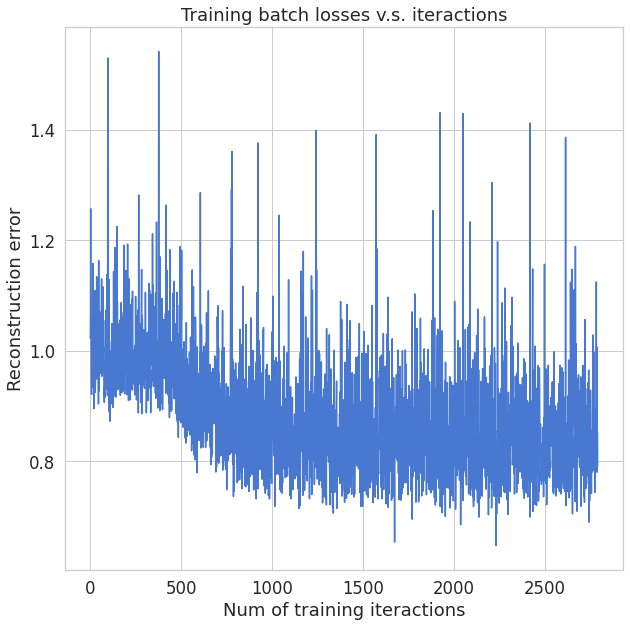

In [20]:
model.fit(train_x, validation_set=test_x)

## Make Predictions 

We then calculate the Free Energy of validation set, and visualize the distributions for both fraud as well as non-fraud samples.

In [21]:
test_cost = model.getFreeEnergy(test_x).reshape(-1)


#### AUC-ROC Test on validation set

We obtained an AUC of around 0.949

In [22]:
auc(test_y, test_cost)

0.962995503457776

#### Visualize the Prediction Result
AUC score (Area Under the ROC Curve) on validation set obtained an AUC of around 0.95 aproximately

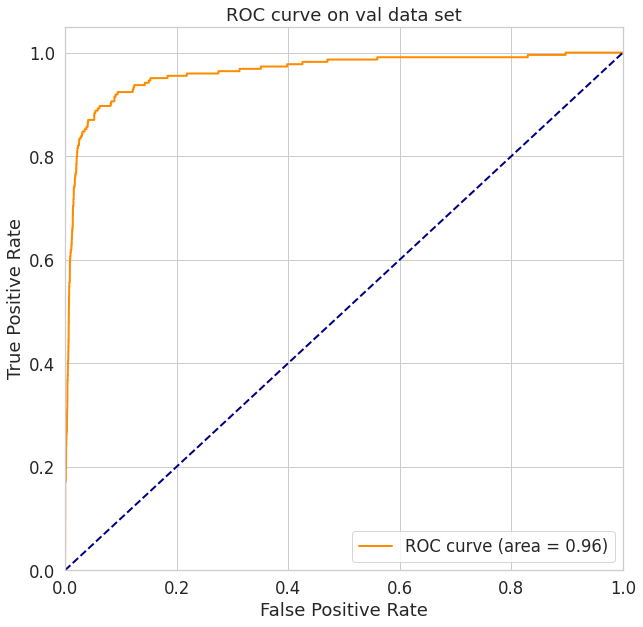

In [23]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(test_y, test_cost)

fpr_micro, tpr_micro, _ = roc_curve(test_y, test_cost)
roc_auc = auc(fpr_micro, tpr_micro)

plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on val data set')
plt.legend(loc="lower right")
plt.show()

### Distribution for Free Energy on validation set - Fraud and Non-fraud

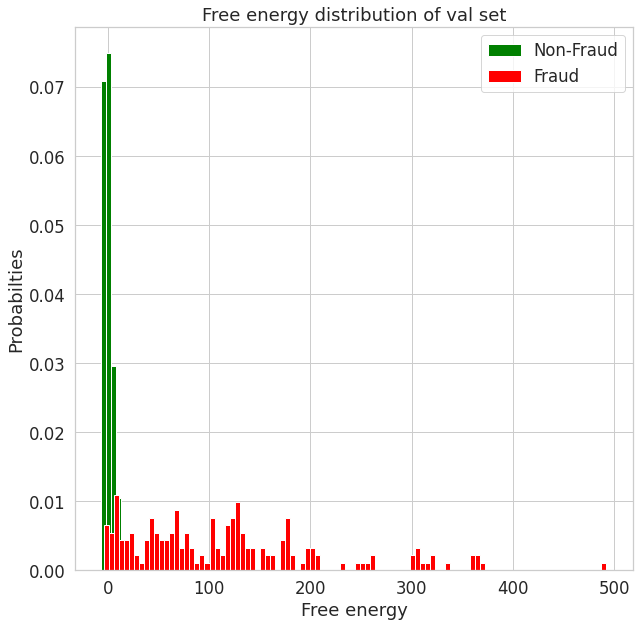

In [24]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.title('Free energy distribution of val set')
plt.xlabel('Free energy')
plt.ylabel('Probabilties')
plt.hist(test_cost[(test_y == 0) & (test_cost < 500)], bins = 100, color='green', density=True, label='Non-Fraud')
plt.hist(test_cost[(test_y == 1) & (test_cost < 500)], bins = 100, color='red', density=True, label = 'Fraud')

plt.legend(loc="upper right")
plt.show()

#### Distribution for Free Energy on validation set - Non-fraud

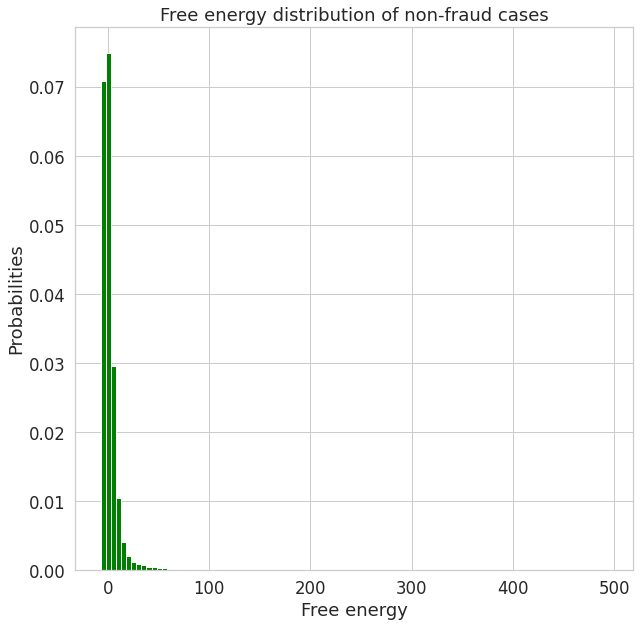

In [25]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.hist(test_cost[(test_y == 0) & (test_cost < 500)], bins = 100, color='green', density=True)
plt.title('Free energy distribution of non-fraud cases')
plt.xlabel('Free energy')
plt.ylabel('Probabilities')
plt.show()

#### Distribution for Free Energy on validation set - Fraud

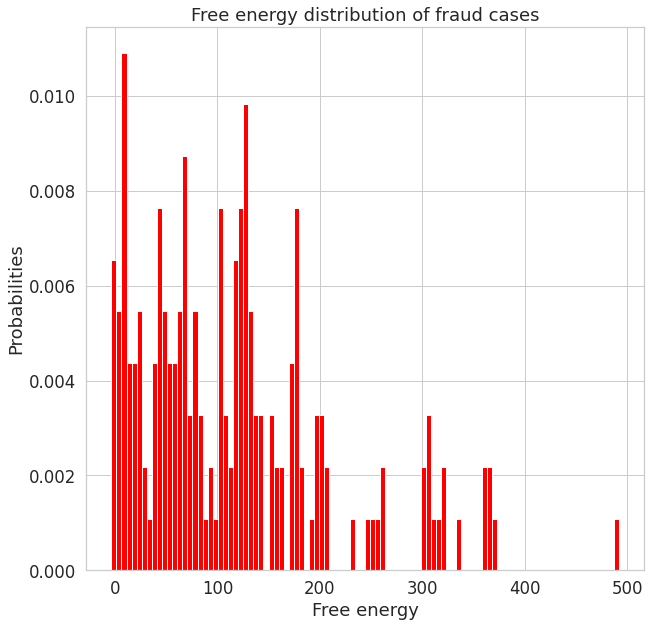

In [26]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.hist(test_cost[(test_y == 1) & (test_cost < 500)], bins = 100, color='red', density=True)
plt.title('Free energy distribution of fraud cases')
plt.xlabel('Free energy')
plt.ylabel('Probabilities')
plt.show()

## Threshold Test¶


### Precision Recall Curve in general

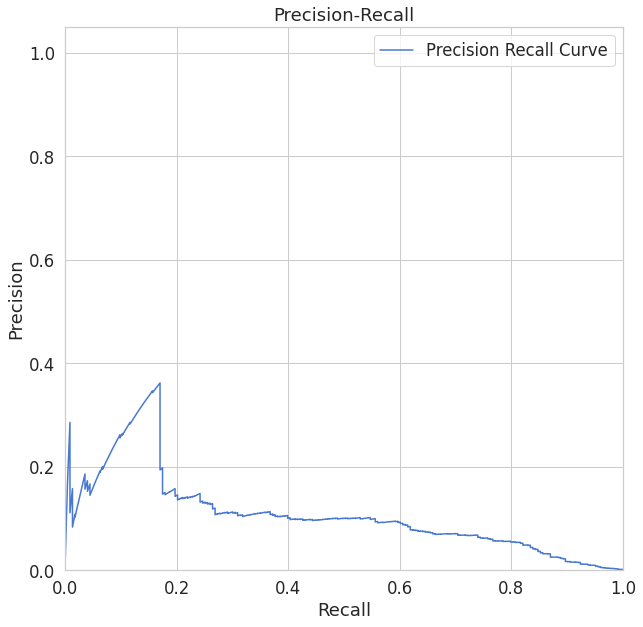

In [27]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall(lines):
    

    for precision, recall, label in lines:
        plt.plot(recall, precision, label=label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall')
    plt.legend(loc="upper right")
    plt.show()
    
lines = []
precision, recall, threshold = precision_recall_curve(test_y, test_cost)

lines.append( (precision, recall, 'Precision Recall Curve') )
plot_precision_recall(lines)

### Finding a threshold of Free Energy on range(0, 200) that best balances Precision and Recall

we will need to find a threshold based on validation data set. This can be done by trading off the precision & recall curves as below (e.g. a value of 100 might give a relative good balance):

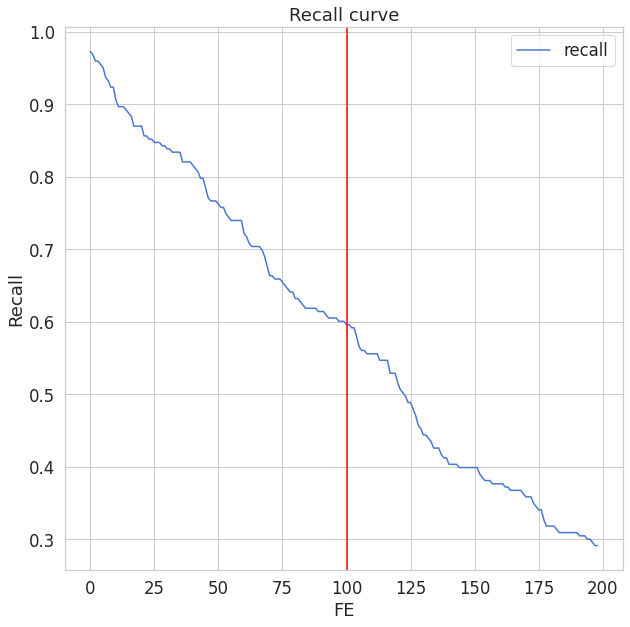

In [28]:
precisions = []
recalls = []
all_pos = sum(test_y)
for threshold in range(1, 200):
    all_predicted = sum(test_cost > threshold)
    TP = sum((test_cost > threshold) & (test_y == 1))
    
    precisions.append(TP  / all_predicted)
    recalls.append(TP / all_pos)

plt.plot( recalls, label = 'recall')
plt.axvline(100, color = 'red')

plt.title("Recall curve")
plt.xlabel("FE")
plt.ylabel("Recall")
plt.legend()
plt.show()

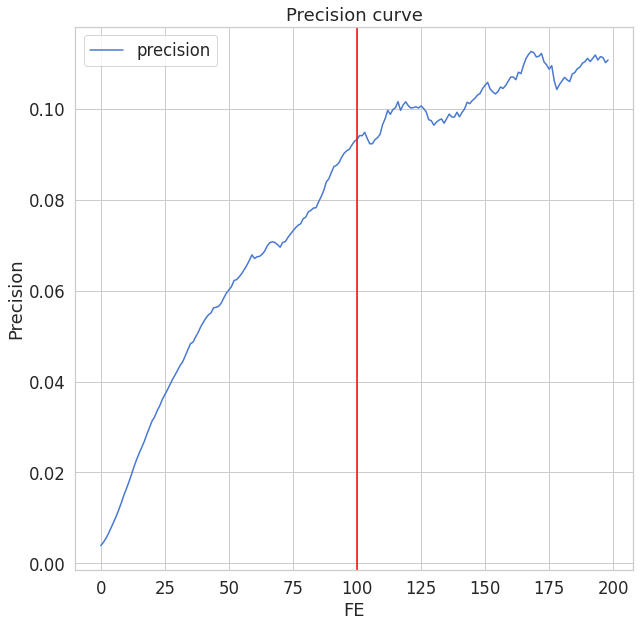

In [29]:
plt.plot( precisions, label = 'precision')
plt.axvline(100, color = 'red')

plt.title("Precision curve")
plt.xlabel("FE")
plt.ylabel("Precision")
plt.legend()
plt.show()

## A further interpretation at the val AUC score of 0.96

There’s another way to intuitively look at the AUC score: the val data’s fraud percentage is around 0.16%;

For example, if we choose top 500 transactions ranked by model’s free energy predictions, the number of fraud is around 11.82% …

So, precision increases from 0.16% to 11.82% in the top 500

In [30]:
value_500 = sorted(test_cost)[-500]
population_mean = np.mean(test_y)
model_mean_500 = np.mean(test_y[test_cost > value_500])
print("Perc of fraud in val data is: %0.2f%%; perc of fraud in top 500 by model is: %0.2f%%" % (population_mean*100, model_mean_500*100))

Perc of fraud in val data is: 0.16%; perc of fraud in top 500 by model is: 12.02%
